# 1. Informações: cidades do estudo e variáveis climáticas

* Estações do INMET: dados de 01/01/2008 à 31/12/2022 (15 anos) 

    1- Paraná - TO (A010); 

    2- Imperatriz - MA (A225);

    3- Bom Jesus do Piauí - PI (A326);

    4- Luíz Eduardo Magalhães - BA (A404);

    5- Casa Branca - SP (A738).

* Variáveis climáticas:
    
    1- Tmax (ºC);

    2- Tmin (ºC);

    3- URmax (%);

    4- URmin (%);

    5- vento (velocidade do vento em metros por segundo (m/s));
    
    6- Rad (Kilojoules por hora (kJ/h)).

# 2. Análise estatística: dados brutos

In [1]:
import math
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import Counter
from datetime import date, datetime
from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carregar as funções:
%run "./plot_graphic.ipynb"
%run "./IQR_find_extreme_values.ipynb"

In [3]:
pd.set_option('float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 20)

In [4]:
# Selecionar a cidade:

# df=pd.read_csv('./Dados_Estacoes/A010.csv', sep = ';') # Paraná - TO (A010)
# df=pd.read_csv('./Dados_Estacoes/A225.csv', sep = ';') # Imperatriz - MA (A225)
# df=pd.read_csv('./Dados_Estacoes/A326.csv', sep = ';') # Bom Jesus do Piauí - PI (A326)
df=pd.read_csv('./Dados_Estacoes/A404.csv', sep = ';') # Luíz Eduardo Magalhães - BA (A404)
# df=pd.read_csv('./Dados_Estacoes/A738.csv', sep = ';') # Casa Branca - SP (A738)

print("Linhas x Colunas: ", df.shape) # linhas x colunas
print("\nTipo de dado: ", type(df)) # tipo de dado
print("\nNome das colunas: ", df.columns) # nome das colunas
print("\nInformações: ")
df.info()

Linhas x Colunas:  (131496, 9)

Tipo de dado:  <class 'pandas.core.frame.DataFrame'>

Nome das colunas:  Index(['Data', 'Hora', 'Prec', 'Rad', 'Tmax', 'Tmin', 'Urmax', 'Urmin',
       'vento'],
      dtype='object')

Informações: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131496 entries, 0 to 131495
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Data    131496 non-null  object 
 1   Hora    131496 non-null  int64  
 2   Prec    107201 non-null  float64
 3   Rad     121329 non-null  float64
 4   Tmax    121438 non-null  float64
 5   Tmin    121438 non-null  float64
 6   Urmax   119590 non-null  float64
 7   Urmin   119998 non-null  float64
 8   vento   121445 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.0+ MB


In [5]:
print(df.head(3)) # primeiras linhas
print("\n")
print(df.tail(3)) # últimas linhas
# df_A010 # todo o dataframe
df[['Prec','Rad','Tmax','Tmin','Urmax','Urmin','vento']].describe()

         Data  Hora  Prec      Rad  Tmax  Tmin  Urmax  Urmin  vento
0  2008-01-01     0   NaN -3539.00 24.30 23.60  60.00  55.00   3.00
1  2008-01-01   100   NaN -3526.00 24.50 23.50  62.00  53.00   2.20
2  2008-01-01   200   NaN  -877.00 25.70 23.70  64.00  51.00   0.00


              Data  Hora  Prec       Rad  Tmax  Tmin  Urmax  Urmin  vento
131493  2022-12-31  2100  0.00 541957.00 30.60 27.50  62.00  50.00   3.00
131494  2022-12-31  2200  0.00      9.51 27.60 25.60  72.00  62.00   3.00
131495  2022-12-31  2300  0.00  -3488.00 25.90 24.80  76.00  70.00   2.50


,Prec,Rad,Tmax,Tmin,Urmax,Urmin,vento
count,107201.00,121329.00,121438.00,121438.00,119590.00,119998.00,121445.00
mean,0.12,780584.00,24.55,22.95,67.93,61.54,2.45
std,1.19,1141701.70,4.74,4.52,21.53,22.38,1.71
min,0.00,-9809.00,10.60,8.90,10.00,10.00,0.00
25%,0.00,-3.54,20.90,19.90,51.00,43.00,1.10
50%,0.00,1745.54,23.80,22.20,71.00,62.00,2.40
75%,0.00,1509822.00,28.40,26.40,88.00,82.00,3.60
max,57.80,4980088.00,39.90,37.00,100.00,100.00,12.50


# 3. Análise estatística: dados pré-processados

In [6]:
# Calcular a média da UR:
df.insert(8,'Urmed', '', allow_duplicates=False)
df['Urmed'] = (df['Urmax'] + df['Urmin'])/2

In [7]:
# 1º) Radiação negativa será igual a NaN:
df['Rad'].where(~(df['Rad'] < 0), other=math.nan, inplace=True)
df.head(25)

,Data,Hora,Prec,Rad,Tmax,Tmin,Urmax,Urmin,Urmed,vento
0,2008-01-01,0,NaN,NaN,24.30,23.60,60.00,55.00,57.50,3.00
1,2008-01-01,100,NaN,NaN,24.50,23.50,62.00,53.00,57.50,2.20
2,2008-01-01,200,NaN,NaN,25.70,23.70,64.00,51.00,57.50,0.00
3,2008-01-01,300,NaN,NaN,23.90,22.60,70.00,62.00,66.00,1.00
4,2008-01-01,400,NaN,NaN,22.60,21.70,74.00,68.00,71.00,2.10
5,2008-01-01,500,NaN,NaN,23.00,22.40,68.00,63.00,65.50,0.20
6,2008-01-01,600,NaN,NaN,22.60,21.10,76.00,64.00,70.00,2.30
7,2008-01-01,700,NaN,NaN,22.50,21.10,77.00,66.00,71.50,0.00
8,2008-01-01,800,NaN,NaN,22.40,20.80,78.00,66.00,72.00,2.30
9,2008-01-01,900,NaN,3709.00,22.50,21.90,67.00,62.00,64.50,2.30


In [8]:
# Inserir novas colunas:
df.insert(10, 'PREC', '', allow_duplicates=False)
df.insert(11, 'RAD', '', allow_duplicates=False)
df.insert(12, 'TMAX', '', allow_duplicates=False)
df.insert(13, 'TMIN', '', allow_duplicates=False)
df.insert(14, 'URMAX', '', allow_duplicates=False)
df.insert(15, 'URMIN', '', allow_duplicates=False)
df.insert(16, 'URMED', '', allow_duplicates=False)
df.insert(17, 'U', '', allow_duplicates=False)

df.head(25)

,Data,Hora,Prec,Rad,Tmax,Tmin,Urmax,Urmin,Urmed,vento,PREC,RAD,TMAX,TMIN,URMAX,URMIN,URMED,U
0,2008-01-01,0,NaN,NaN,24.30,23.60,60.00,55.00,57.50,3.00,,,,,,,,
1,2008-01-01,100,NaN,NaN,24.50,23.50,62.00,53.00,57.50,2.20,,,,,,,,
2,2008-01-01,200,NaN,NaN,25.70,23.70,64.00,51.00,57.50,0.00,,,,,,,,
3,2008-01-01,300,NaN,NaN,23.90,22.60,70.00,62.00,66.00,1.00,,,,,,,,
4,2008-01-01,400,NaN,NaN,22.60,21.70,74.00,68.00,71.00,2.10,,,,,,,,
5,2008-01-01,500,NaN,NaN,23.00,22.40,68.00,63.00,65.50,0.20,,,,,,,,
6,2008-01-01,600,NaN,NaN,22.60,21.10,76.00,64.00,70.00,2.30,,,,,,,,
7,2008-01-01,700,NaN,NaN,22.50,21.10,77.00,66.00,71.50,0.00,,,,,,,,
8,2008-01-01,800,NaN,NaN,22.40,20.80,78.00,66.00,72.00,2.30,,,,,,,,
9,2008-01-01,900,NaN,3709.00,22.50,21.90,67.00,62.00,64.50,2.30,,,,,,,,


In [9]:
# Soma: PREC e RAD:
df.loc[0:23, "PREC"] = np.nansum(df.loc[0:23,"Prec"])

# 2º) Correção da radiação: kJ m-2 dia-1 para MJ m-2 dia-1
df.loc[0:23,  "RAD"] = (np.nansum(df.loc[0:23,"Rad"]))/1000

# Média: TMAX e TMIN:
df.loc[0:23, "TMAX"] = np.nanmean(df.loc[0:23,"Tmax"])
df.loc[0:23, "TMIN"] = np.nanmean(df.loc[0:23,"Tmin"])

# Média: URMAX e URMIN:
df.loc[0:23,"URMAX"] = np.nanmean(df.loc[0:23,"Urmax"])
df.loc[0:23,"URMIN"] = np.nanmean(df.loc[0:23,"Urmin"])
df.loc[0:23,"URMED"] = np.nanmean(df.loc[0:23,"Urmed"])

# Média: U (vento):
df.loc[0:23,"U"] = np.nanmean(df.loc[0:23,"vento"])

df.head(25)

,Data,Hora,Prec,Rad,Tmax,Tmin,Urmax,Urmin,Urmed,vento,PREC,RAD,TMAX,TMIN,URMAX,URMIN,URMED,U
0,2008-01-01,0,NaN,NaN,24.30,23.60,60.00,55.00,57.50,3.00,0.00,22780.18,26.99,25.33,57.46,49.38,53.42,2.34
1,2008-01-01,100,NaN,NaN,24.50,23.50,62.00,53.00,57.50,2.20,0.00,22780.18,26.99,25.33,57.46,49.38,53.42,2.34
2,2008-01-01,200,NaN,NaN,25.70,23.70,64.00,51.00,57.50,0.00,0.00,22780.18,26.99,25.33,57.46,49.38,53.42,2.34
3,2008-01-01,300,NaN,NaN,23.90,22.60,70.00,62.00,66.00,1.00,0.00,22780.18,26.99,25.33,57.46,49.38,53.42,2.34
4,2008-01-01,400,NaN,NaN,22.60,21.70,74.00,68.00,71.00,2.10,0.00,22780.18,26.99,25.33,57.46,49.38,53.42,2.34
5,2008-01-01,500,NaN,NaN,23.00,22.40,68.00,63.00,65.50,0.20,0.00,22780.18,26.99,25.33,57.46,49.38,53.42,2.34
6,2008-01-01,600,NaN,NaN,22.60,21.10,76.00,64.00,70.00,2.30,0.00,22780.18,26.99,25.33,57.46,49.38,53.42,2.34
7,2008-01-01,700,NaN,NaN,22.50,21.10,77.00,66.00,71.50,0.00,0.00,22780.18,26.99,25.33,57.46,49.38,53.42,2.34
8,2008-01-01,800,NaN,NaN,22.40,20.80,78.00,66.00,72.00,2.30,0.00,22780.18,26.99,25.33,57.46,49.38,53.42,2.34
9,2008-01-01,900,NaN,3709.00,22.50,21.90,67.00,62.00,64.50,2.30,0.00,22780.18,26.99,25.33,57.46,49.38,53.42,2.34


In [10]:
start = 24
finish = 47

for row in df.itertuples():
    df.loc[start:finish,"PREC"] = np.nansum(df.loc[start:finish,"Prec"])

    # 2º) Correção da radiação: kJ m-2 dia-1 para MJ m-2 dia-1
    df.loc[start:finish,"RAD"] = (np.nansum(df.loc[start:finish,"Rad"]))/1000

    df.loc[start:finish,"TMAX"] = np.nanmean(df.loc[start:finish,"Tmax"])
    df.loc[start:finish,"TMIN"] = np.nanmean(df.loc[start:finish,"Tmin"])

    df.loc[start:finish,"URMAX"] = np.nanmean(df.loc[start:finish,"Urmax"])
    df.loc[start:finish,"URMIN"] = np.nanmean(df.loc[start:finish,"Urmin"])
    df.loc[start:finish,"URMED"] = np.nanmean(df.loc[start:finish,"Urmed"])

    df.loc[start:finish,"U"] = np.nanmean(df.loc[start:finish,"vento"])
    
    start += 24
    finish += 24

df.head(25)

,Data,Hora,Prec,Rad,Tmax,Tmin,Urmax,Urmin,Urmed,vento,PREC,RAD,TMAX,TMIN,URMAX,URMIN,URMED,U
0,2008-01-01,0,NaN,NaN,24.30,23.60,60.00,55.00,57.50,3.00,0.00,22780.18,26.99,25.33,57.46,49.38,53.42,2.34
1,2008-01-01,100,NaN,NaN,24.50,23.50,62.00,53.00,57.50,2.20,0.00,22780.18,26.99,25.33,57.46,49.38,53.42,2.34
2,2008-01-01,200,NaN,NaN,25.70,23.70,64.00,51.00,57.50,0.00,0.00,22780.18,26.99,25.33,57.46,49.38,53.42,2.34
3,2008-01-01,300,NaN,NaN,23.90,22.60,70.00,62.00,66.00,1.00,0.00,22780.18,26.99,25.33,57.46,49.38,53.42,2.34
4,2008-01-01,400,NaN,NaN,22.60,21.70,74.00,68.00,71.00,2.10,0.00,22780.18,26.99,25.33,57.46,49.38,53.42,2.34
5,2008-01-01,500,NaN,NaN,23.00,22.40,68.00,63.00,65.50,0.20,0.00,22780.18,26.99,25.33,57.46,49.38,53.42,2.34
6,2008-01-01,600,NaN,NaN,22.60,21.10,76.00,64.00,70.00,2.30,0.00,22780.18,26.99,25.33,57.46,49.38,53.42,2.34
7,2008-01-01,700,NaN,NaN,22.50,21.10,77.00,66.00,71.50,0.00,0.00,22780.18,26.99,25.33,57.46,49.38,53.42,2.34
8,2008-01-01,800,NaN,NaN,22.40,20.80,78.00,66.00,72.00,2.30,0.00,22780.18,26.99,25.33,57.46,49.38,53.42,2.34
9,2008-01-01,900,NaN,3709.00,22.50,21.90,67.00,62.00,64.50,2.30,0.00,22780.18,26.99,25.33,57.46,49.38,53.42,2.34


In [11]:
# Criar novo dataframe com cópia do df anterior:
new_df = df[['Data','PREC','RAD','TMAX','TMIN','URMED','U']].copy()
pd.DataFrame(new_df)
# new_df.head(25)
# print("Linhas x Colunas: ", new_df.shape)
new_df

,Data,PREC,RAD,TMAX,TMIN,URMED,U
0,2008-01-01,0.00,22780.18,26.99,25.33,53.42,2.34
1,2008-01-01,0.00,22780.18,26.99,25.33,53.42,2.34
2,2008-01-01,0.00,22780.18,26.99,25.33,53.42,2.34
3,2008-01-01,0.00,22780.18,26.99,25.33,53.42,2.34
4,2008-01-01,0.00,22780.18,26.99,25.33,53.42,2.34
...,...,...,...,...,...,...,...
131491,2022-12-31,0.00,23277.82,26.16,24.52,73.60,1.52
131492,2022-12-31,0.00,23277.82,26.16,24.52,73.60,1.52
131493,2022-12-31,0.00,23277.82,26.16,24.52,73.60,1.52
131494,2022-12-31,0.00,23277.82,26.16,24.52,73.60,1.52


In [12]:
# Eliminar linhas duplicadas:
new_df.drop_duplicates(inplace=True)

# Resetar o índice sem criar uma nova coluna:
new_df = new_df.reset_index(drop=True)
new_df.head(10)

,Data,PREC,RAD,TMAX,TMIN,URMED,U
0,2008-01-01,0.00,22780.18,26.99,25.33,53.42,2.34
1,2008-01-02,0.00,25049.65,26.11,24.55,64.44,2.12
2,2008-01-03,0.00,22079.97,26.35,24.97,64.29,2.22
3,2008-01-04,0.00,37781.83,26.74,25.10,51.65,2.65
4,2008-01-05,0.00,32782.26,26.76,24.68,38.04,2.55
5,2008-01-06,0.00,27304.92,26.89,24.92,46.60,2.06
6,2008-01-07,0.00,13774.56,25.81,24.79,63.23,3.06
7,2008-01-08,0.00,17124.81,23.89,22.64,74.94,2.67
8,2008-01-09,0.00,19944.92,23.46,22.28,78.02,2.08
9,2008-01-10,0.00,12166.80,22.54,21.80,81.00,1.80


In [13]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5479 entries, 0 to 5478
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    5479 non-null   object
 1   PREC    5479 non-null   object
 2   RAD     5479 non-null   object
 3   TMAX    5115 non-null   object
 4   TMIN    5115 non-null   object
 5   URMED   5115 non-null   object
 6   U       5115 non-null   object
dtypes: object(7)
memory usage: 299.8+ KB


In [14]:
# Converter de object para float64:

new_df['PREC'] = new_df['PREC'].astype(float)
new_df['RAD'] = new_df['RAD'].astype(float)

new_df['TMAX'] = new_df['TMAX'].astype(float)
new_df['TMIN'] = new_df['TMIN'].astype(float)

new_df['URMED'] = new_df['URMED'].astype(float)

new_df['U'] = new_df['U'].astype(float)

new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5479 entries, 0 to 5478
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Data    5479 non-null   object 
 1   PREC    5479 non-null   float64
 2   RAD     5479 non-null   float64
 3   TMAX    5115 non-null   float64
 4   TMIN    5115 non-null   float64
 5   URMED   5115 non-null   float64
 6   U       5115 non-null   float64
dtypes: float64(6), object(1)
memory usage: 299.8+ KB


In [15]:
# Realizar pesquisa nos dados para saber se será necessário a correção:

'''
XAVIER, A. C.; KINGB, C. W.; SCANLONC, B. R. Daily gridded meteorological variables in Brazil (1980-2013).
International Journal of Climatology, Wiley Online Library, v. 36, p. 2644-2659, 2016.
'''

# PREC:
print('PREC < 0: ', new_df.query("PREC < 0")) 

PREC < 0:  Empty DataFrame
Columns: [Data, PREC, RAD, TMAX, TMIN, URMED, U]
Index: []


In [16]:
# PREC:
print('\nPREC > 450: ', new_df.query("PREC > 450"))


PREC > 450:  Empty DataFrame
Columns: [Data, PREC, RAD, TMAX, TMIN, URMED, U]
Index: []


In [17]:
# TMAX:
print('\nTMAX <= -30: ', new_df.query("TMAX <= -30"))


TMAX <= -30:  Empty DataFrame
Columns: [Data, PREC, RAD, TMAX, TMIN, URMED, U]
Index: []


In [18]:
# TMIN:
print('\nTMIN > 50: ', new_df.query("TMIN > 50"))


TMIN > 50:  Empty DataFrame
Columns: [Data, PREC, RAD, TMAX, TMIN, URMED, U]
Index: []


In [19]:
# URMED:
print('\nURMED > 100: ', new_df.query("URMED > 100"))


URMED > 100:  Empty DataFrame
Columns: [Data, PREC, RAD, TMAX, TMIN, URMED, U]
Index: []


In [20]:
# URMED:
print('\nURMED <= 0: ', new_df.query("URMED <= 0"))


URMED <= 0:  Empty DataFrame
Columns: [Data, PREC, RAD, TMAX, TMIN, URMED, U]
Index: []


In [21]:
# U:
print('\nU < 0: ', new_df.query("U < 0"))


U < 0:  Empty DataFrame
Columns: [Data, PREC, RAD, TMAX, TMIN, URMED, U]
Index: []


In [22]:
# U:
print('\nU > 100: ', new_df.query("U > 100"))


U > 100:  Empty DataFrame
Columns: [Data, PREC, RAD, TMAX, TMIN, URMED, U]
Index: []


In [23]:
new_df[['PREC','RAD','TMAX','TMIN','URMED','U']].describe()

,PREC,RAD,TMAX,TMIN,URMED,U
count,5479.00,5479.00,5115.00,5115.00,5115.00,5115.00
mean,2.36,17297.39,24.58,22.98,64.95,2.45
std,7.94,6635.36,1.93,1.81,15.56,1.04
min,0.00,0.00,18.68,17.20,24.40,0.00
25%,0.00,14566.35,23.18,21.73,53.12,1.76
50%,0.00,18425.70,24.36,22.86,66.06,2.34
75%,0.00,21542.07,25.79,24.13,77.77,3.08
max,98.00,37781.83,34.10,33.10,98.32,6.07


# 4. Detectar os pontos extremos 

## 4.1. Estatística descritiva: Histogramas x Gráfico Quantil x Boxplot

In [24]:
# Medir o grau de simetria da curva, em relação a distribuição normal:
# Se skew = 0 -> distribuição simétrica;
# Se skew > 0 -> assimétrica positiva (à direita);
# Se skew < 0 -> assimétrica negativa (à esquerda).

print('PREC:', new_df['PREC'].skew())
print('RAD:', new_df['RAD'].skew())
print('TMAX:', new_df['TMAX'].skew())
print('TMIN:', new_df['TMIN'].skew())
print('URMED:', new_df['URMED'].skew())
print('U:', new_df['U'].skew())

PREC: 5.221626483790017
RAD: -0.991822068128594
TMAX: 0.48035993044290604
TMIN: 0.3653430344870209
URMED: -0.2712140852918385
U: 0.3674000533021914


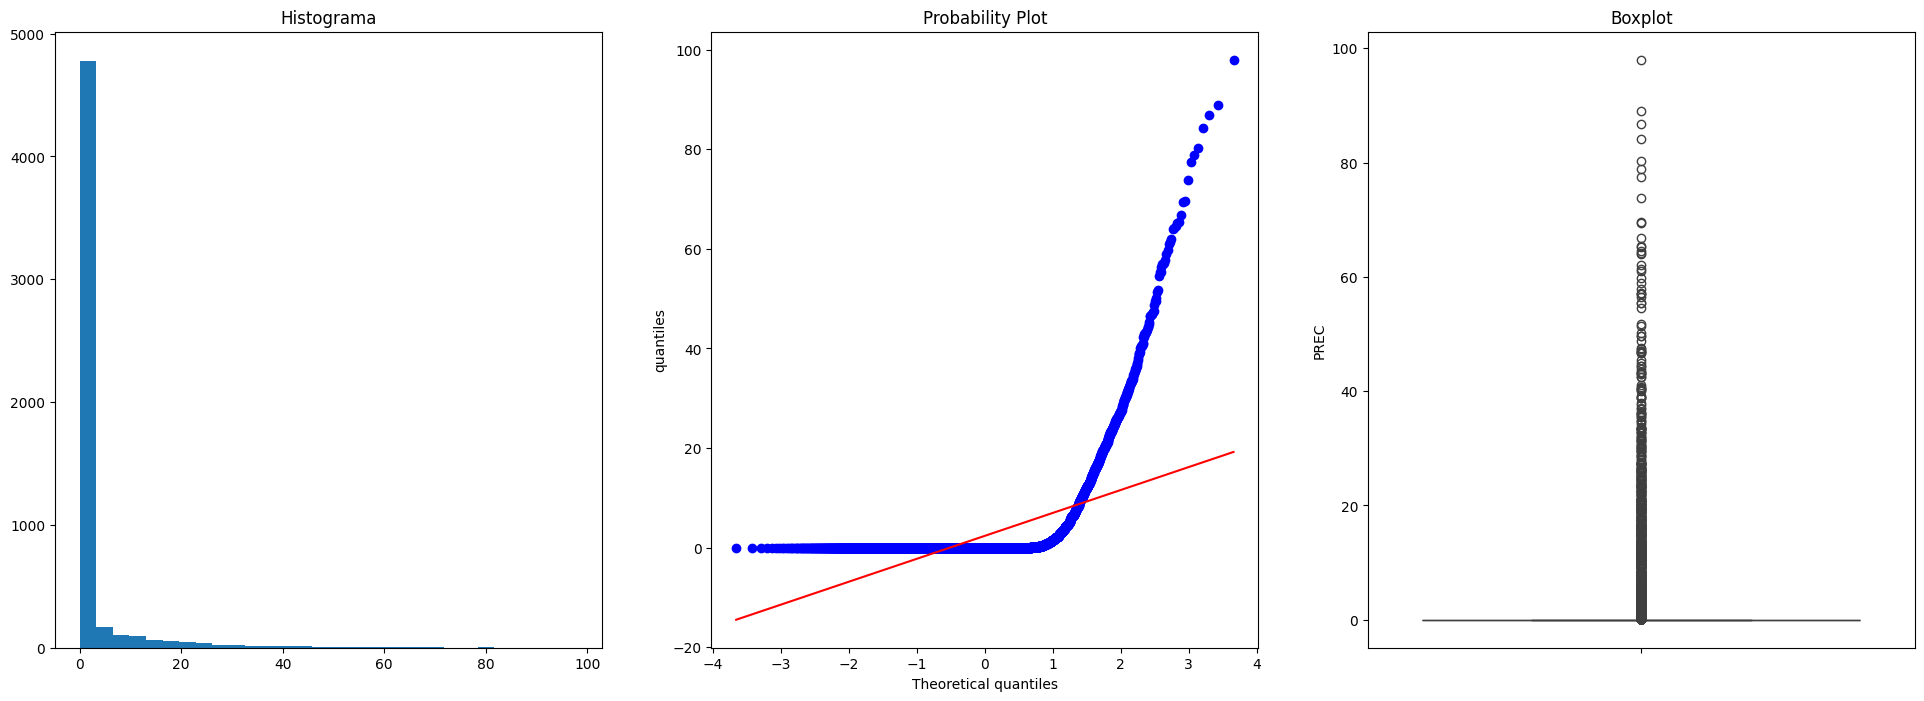

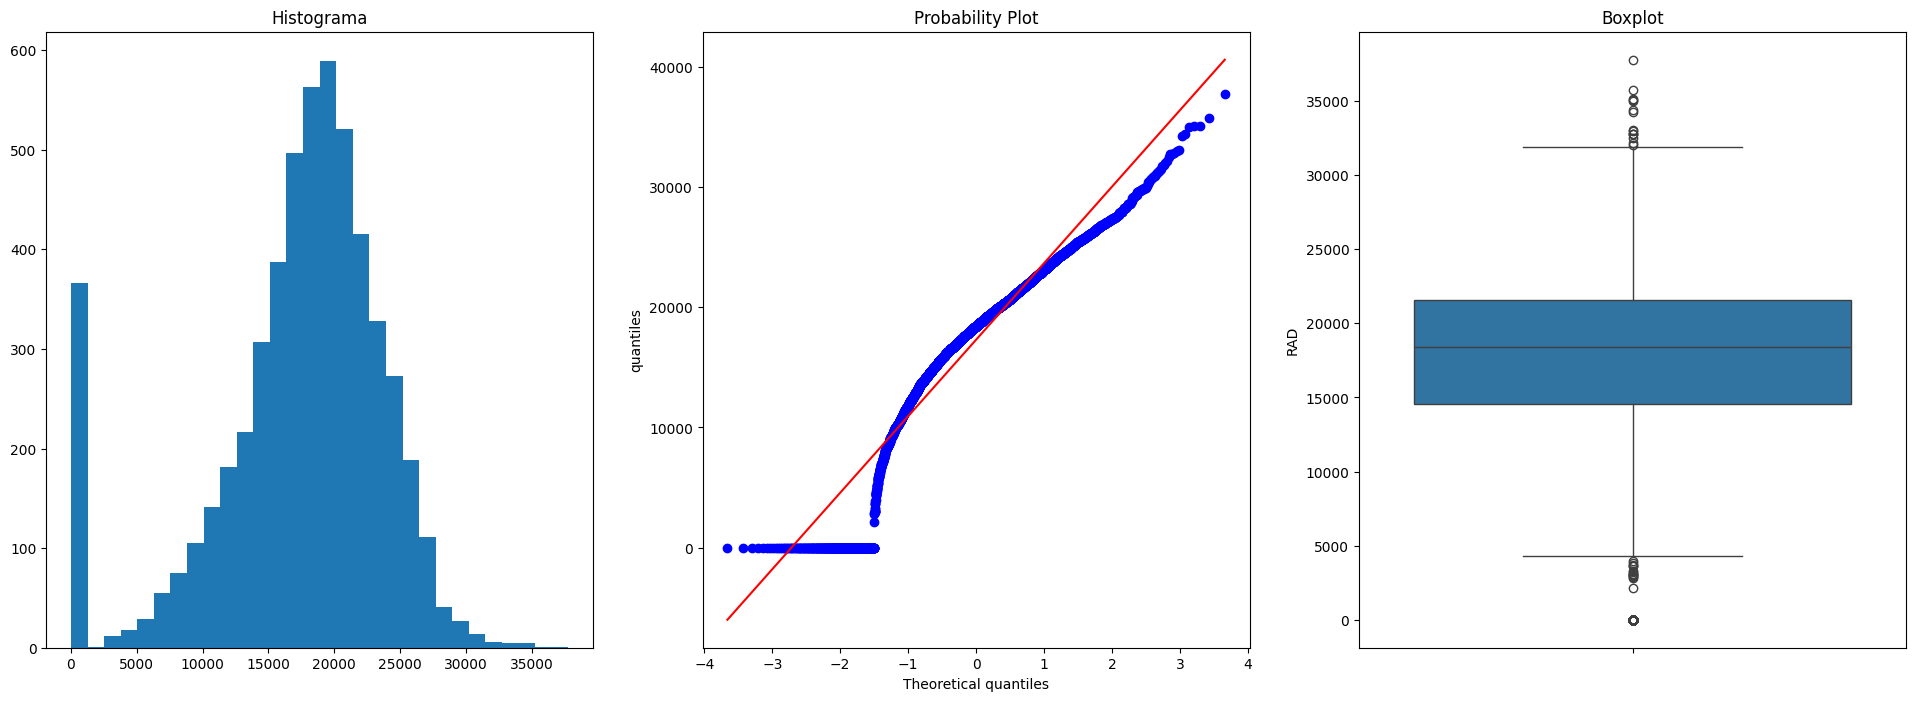

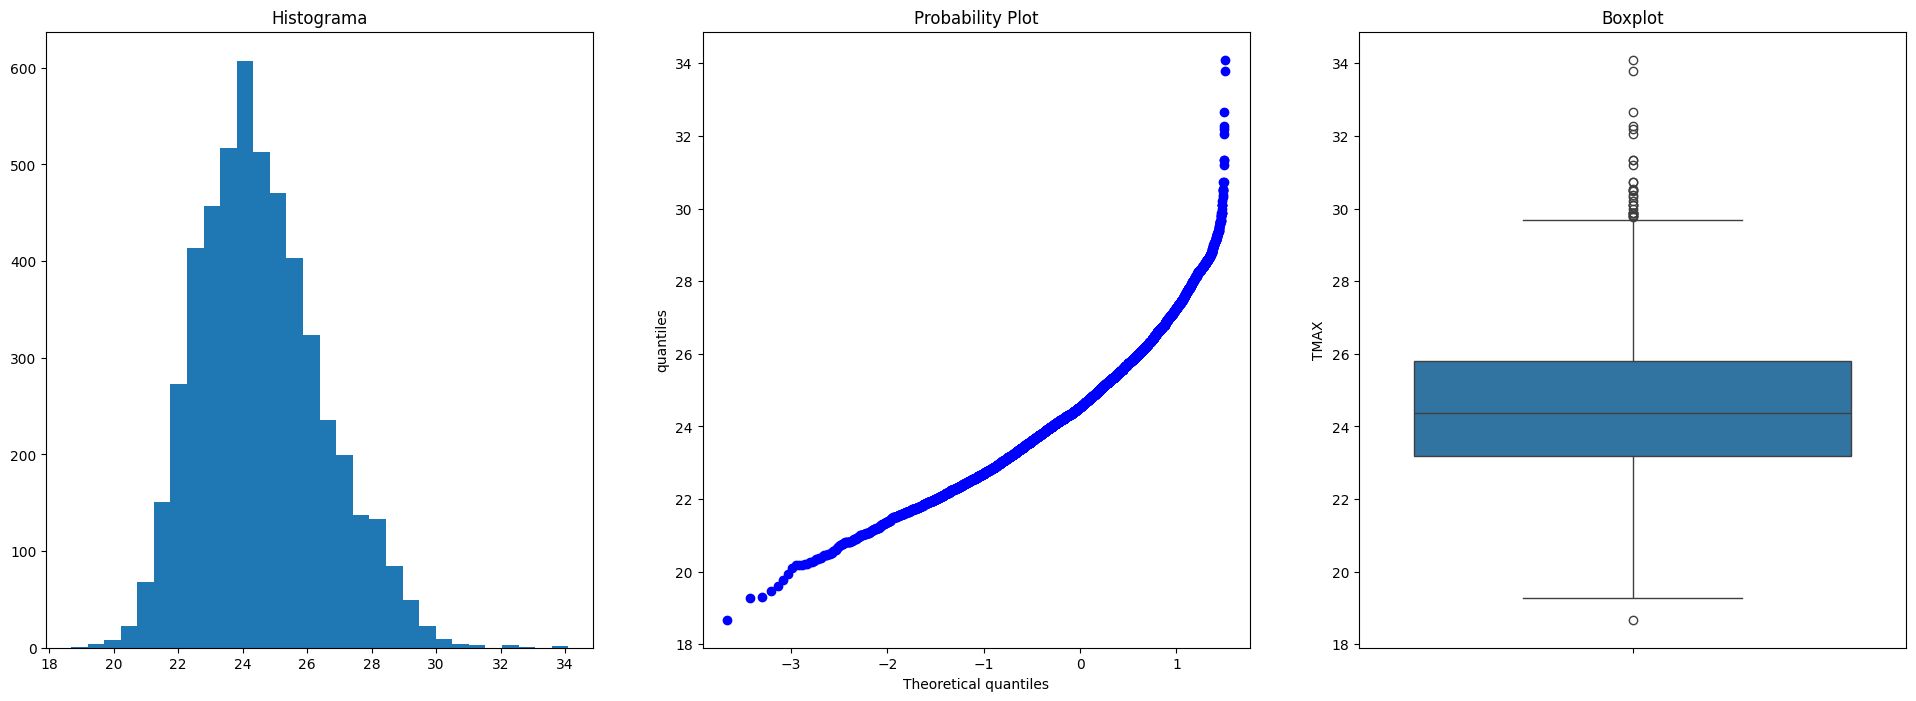

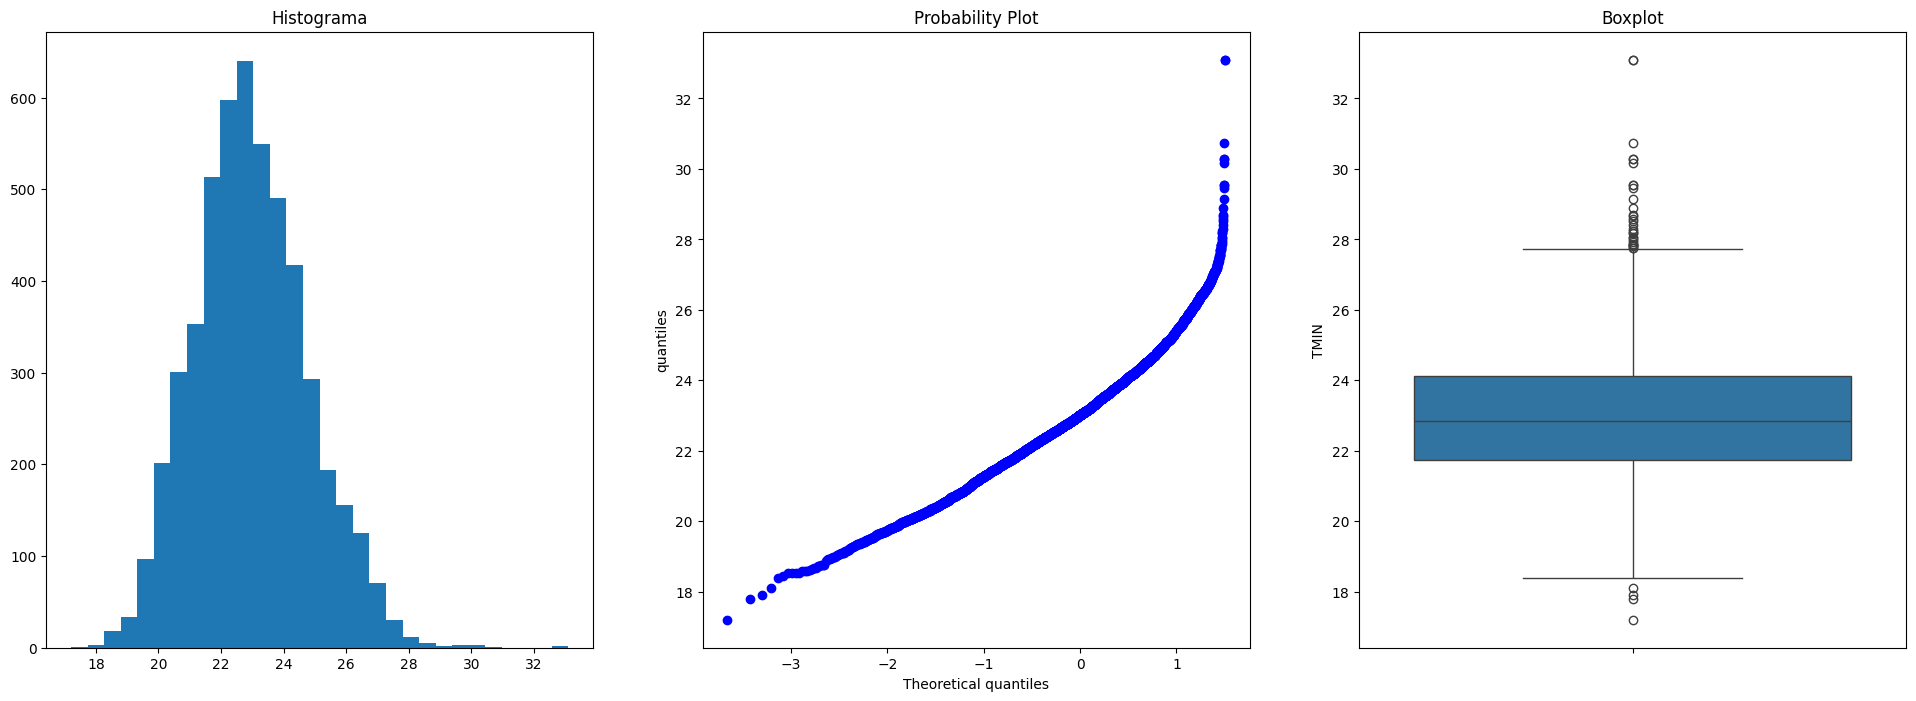

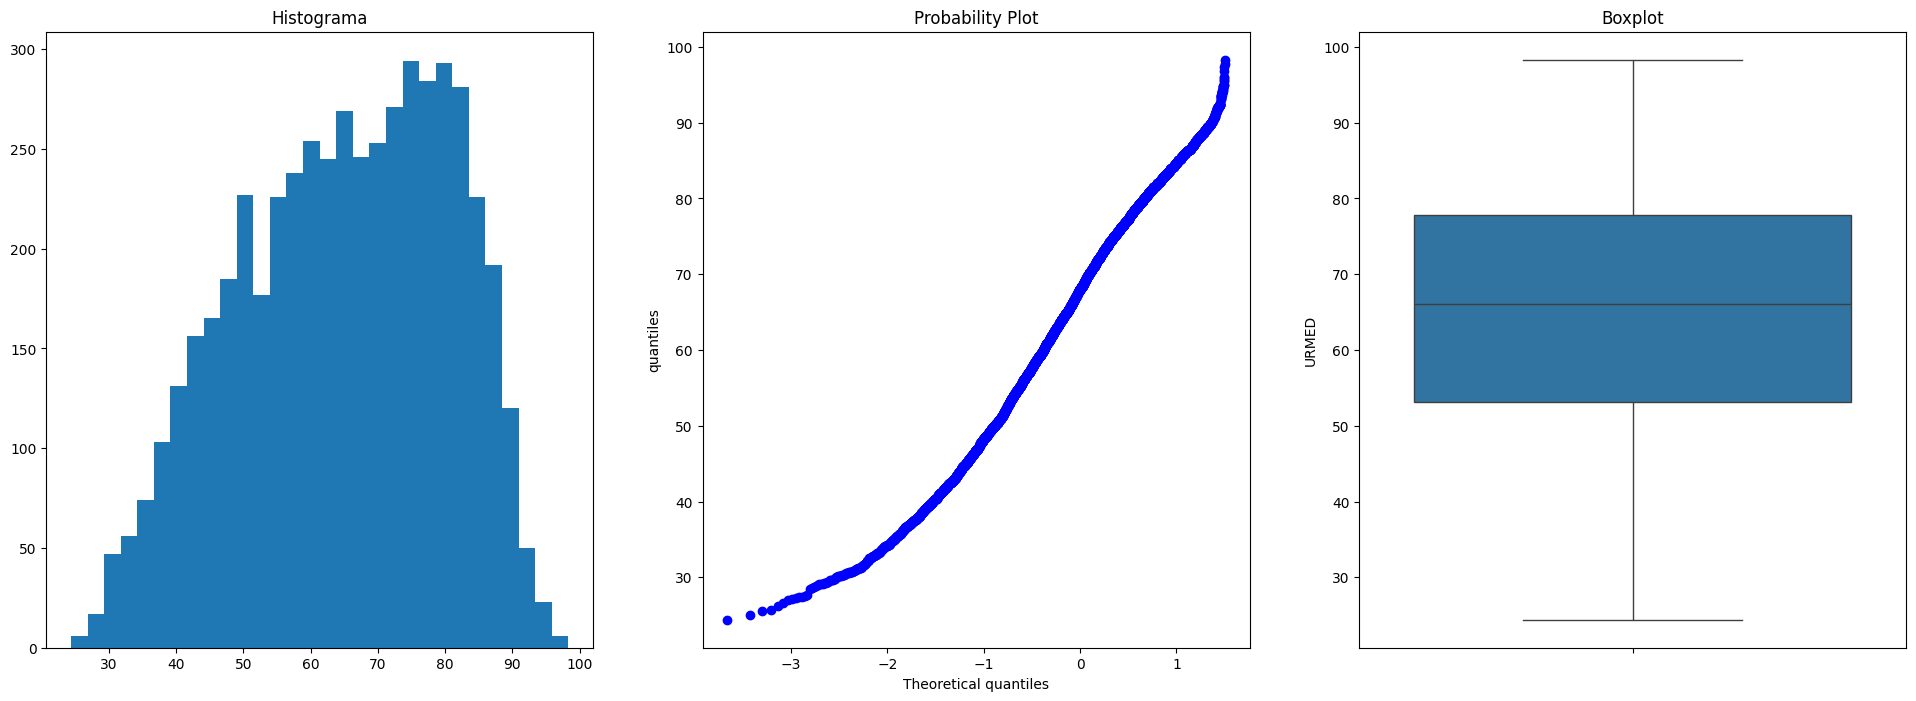

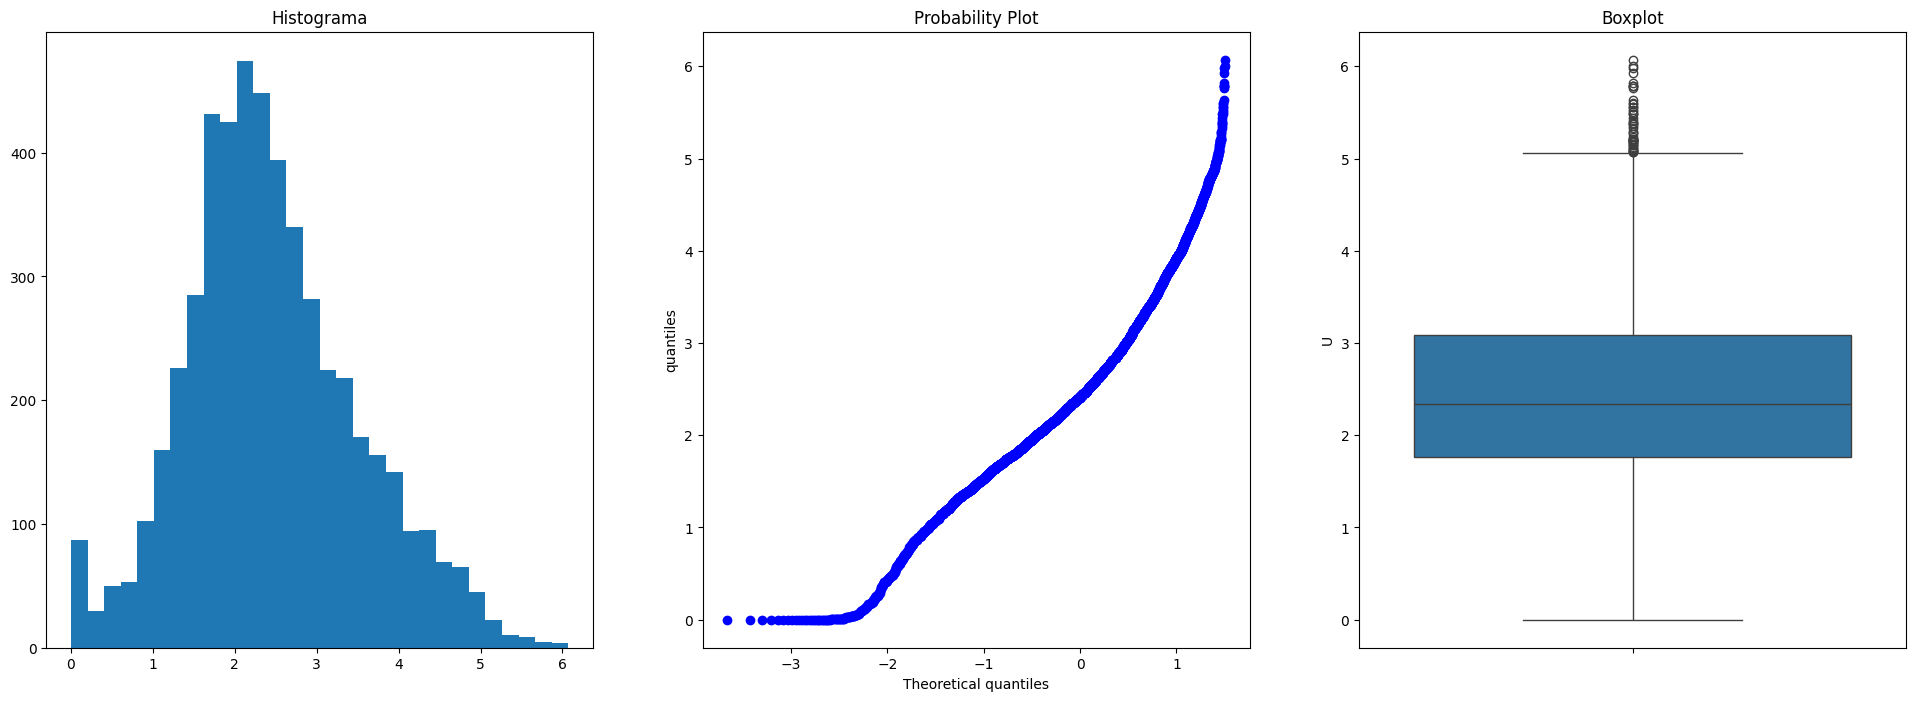

In [25]:
# Plotar o gráfico:

plot_graphic(new_df,'PREC')
plot_graphic(new_df,'RAD')
plot_graphic(new_df,'TMAX')
plot_graphic(new_df,'TMIN')
plot_graphic(new_df,'URMED')
plot_graphic(new_df,'U')

In [26]:
# Encontrar o valor extremo pelo método IQR:

IQR_find_extreme_values(new_df,'PREC', 1.5)

MÉTODO DO INTERVALO INTERQUARTIL OU IQR
-----------------------------------------
PREC
3º quartil: 0.0
1º quartil: 0.0
LS de PREC : 0.0
LI de PREC : 0.0
Qtd acima de LS: 1369
Qtd abaixo de LI: 0
LS(%): 24.98631137068808
LI(%): 0.0
Tabela com os valores acima dos limites: 
             Data  PREC      RAD  TMAX  TMIN  URMED    U
430   2009-03-06 10.00  6427.10 25.47 22.60  67.75 2.84
432   2009-03-08 12.00 14239.66 23.67 21.89  81.96 1.39
433   2009-03-09 19.40 13367.35 22.08 20.97  85.73 1.46
434   2009-03-10  0.20 22535.17 24.09 22.73  76.60 1.57
436   2009-03-12  0.20 22306.88 24.94 23.40  73.10 2.37
...          ...   ...      ...   ...   ...    ...  ...
5470  2022-12-23 11.80 13966.46 23.36 21.84  87.68 2.01
5471  2022-12-24 42.40 16605.30 22.41 21.29  87.89 1.38
5472  2022-12-25 22.80 14617.21 22.55 21.35  90.80 1.55
5473  2022-12-26 10.40  8065.97 21.96 21.12  92.35 0.74
5474  2022-12-27  0.20 18294.71 24.56 23.23  79.55 1.74

[1369 rows x 7 columns]


In [27]:
IQR_find_extreme_values(new_df,'RAD', 1.5)

MÉTODO DO INTERVALO INTERQUARTIL OU IQR
-----------------------------------------
RAD
3º quartil: 21542.0705
1º quartil: 14566.354855
LS de RAD : 32005.643967500004
LI de RAD : 4102.781387499997
Qtd acima de LS: 15
Qtd abaixo de LI: 381
LS(%): 0.27377258623836465
LI(%): 6.953823690454462
Tabela com os valores acima dos limites: 
             Data  PREC      RAD  TMAX  TMIN  URMED    U
3     2008-01-04  0.00 37781.83 26.74 25.10  51.65 2.65
4     2008-01-05  0.00 32782.26 26.76 24.68  38.04 2.55
13    2008-01-14  0.00 34395.74 26.71 24.83  52.56 3.92
24    2008-01-25  0.00 32162.05 26.05 24.43  61.25 3.21
42    2008-02-12  0.00 35085.02 24.90 23.62  68.31 2.30
...          ...   ...      ...   ...   ...    ...  ...
4988  2021-08-28  0.00     0.00   NaN   NaN    NaN  NaN
4989  2021-08-29  0.00     0.00   NaN   NaN    NaN  NaN
4990  2021-08-30  0.00     0.00   NaN   NaN    NaN  NaN
4991  2021-08-31  0.00     0.00   NaN   NaN    NaN  NaN
5107  2021-12-25 22.60  3271.67 21.55 20.93  96.07 2

In [28]:
IQR_find_extreme_values(new_df,'TMAX', 1.5)

MÉTODO DO INTERVALO INTERQUARTIL OU IQR
-----------------------------------------
TMAX
3º quartil: 25.791666666666668
1º quartil: 23.175
LS de TMAX : 29.71666666666667
LI de TMAX : 19.25
Qtd acima de LS: 30
Qtd abaixo de LI: 1
LS(%): 0.5475451724767293
LI(%): 0.018251505749224312
Tabela com os valores acima dos limites: 
             Data  PREC      RAD  TMAX  TMIN  URMED    U
308   2008-11-04  0.00 26866.82 30.47 28.52  26.54 2.41
1758  2012-10-24  0.00 25495.17 29.76 28.03  44.71 2.83
1759  2012-10-25  0.00 22425.14 31.34 29.55  32.85 3.81
1810  2012-12-15  0.00     0.65 30.50 28.30  55.00 2.80
1811  2012-12-16  0.00  3703.54 33.80 33.10  25.00 4.60
1812  2012-12-17  0.00  4859.70 34.10 33.10  25.50 1.90
1813  2012-12-18  0.00  9594.11 32.65 30.75  32.92 3.39
1814  2012-12-19  0.00  7031.68 32.28 30.28  26.25 4.35
1815  2012-12-20  0.00 17097.30 31.20 29.45  31.23 4.28
1816  2012-12-21  0.00 23770.46 32.05 30.17  34.32 3.46
1817  2012-12-22  0.00 18154.82 31.34 29.54  36.23 3.28
2102

In [29]:
IQR_find_extreme_values(new_df,'TMIN', 1.5)

MÉTODO DO INTERVALO INTERQUARTIL OU IQR
-----------------------------------------
TMIN
3º quartil: 24.129166666666663
1º quartil: 21.725
LS de TMIN : 27.735416666666655
LI de TMIN : 18.11875000000001
Qtd acima de LS: 31
Qtd abaixo de LI: 4
LS(%): 0.5657966782259536
LI(%): 0.07300602299689725
Tabela com os valores acima dos limites: 
             Data  PREC      RAD  TMAX  TMIN  URMED    U
195   2008-07-14  0.00 22464.03 19.48 17.80  46.12 4.37
308   2008-11-04  0.00 26866.82 30.47 28.52  26.54 2.41
1011  2010-10-08  0.00 15168.73 29.34 27.98  42.48 2.27
1758  2012-10-24  0.00 25495.17 29.76 28.03  44.71 2.83
1759  2012-10-25  0.00 22425.14 31.34 29.55  32.85 3.81
1810  2012-12-15  0.00     0.65 30.50 28.30  55.00 2.80
1811  2012-12-16  0.00  3703.54 33.80 33.10  25.00 4.60
1812  2012-12-17  0.00  4859.70 34.10 33.10  25.50 1.90
1813  2012-12-18  0.00  9594.11 32.65 30.75  32.92 3.39
1814  2012-12-19  0.00  7031.68 32.28 30.28  26.25 4.35
1815  2012-12-20  0.00 17097.30 31.20 29.45  31.

In [30]:
IQR_find_extreme_values(new_df,'URMED', 1.5)

MÉTODO DO INTERVALO INTERQUARTIL OU IQR
-----------------------------------------
URMED
3º quartil: 77.7717803030303
1º quartil: 53.125
LS de URMED : 114.74195075757575
LI de URMED : 16.154829545454554
Qtd acima de LS: 0
Qtd abaixo de LI: 0
LS(%): 0.0
LI(%): 0.0
Tabela com os valores acima dos limites: 
 Empty DataFrame
Columns: [Data, PREC, RAD, TMAX, TMIN, URMED, U]
Index: []


In [31]:
IQR_find_extreme_values(new_df,'U', 1.5)

MÉTODO DO INTERVALO INTERQUARTIL OU IQR
-----------------------------------------
U
3º quartil: 3.0833333333333335
1º quartil: 1.763068181818182
LS de U : 5.063731060606061
LI de U : -0.21732954545454541
Qtd acima de LS: 50
Qtd abaixo de LI: 0
LS(%): 0.9125752874612155
LI(%): 0.0
Tabela com os valores acima dos limites: 
             Data  PREC      RAD  TMAX  TMIN  URMED    U
196   2008-07-15  0.00 25778.87 20.81 19.52  54.33 5.17
197   2008-07-16  0.00 20519.88 21.03 19.63  46.65 5.56
283   2008-10-10  0.00 30582.81 26.09 24.55  41.58 5.18
284   2008-10-11  0.00 26030.22 26.15 24.65  45.81 5.48
285   2008-10-12  0.00 31762.64 26.45 24.88  44.52 5.21
590   2009-08-13  0.00 23326.46 23.09 21.31  46.15 5.20
619   2009-09-11  0.00 25707.49 24.84 23.12  47.67 5.28
927   2010-07-16  0.00 15656.33 22.85 21.03  55.25 5.19
928   2010-07-17  0.00 16991.31 23.07 21.95  63.77 5.14
961   2010-08-19  0.00 22797.45 20.21 18.60  45.08 5.20
974   2010-09-01  0.00 18417.58 23.77 22.17  48.56 5.24
983 

In [32]:
# Salvar o dataframe pré-processado:

# new_df.to_csv('./Dados_Processados/A010_PP.csv')
# new_df.to_csv('./Dados_Processados/A225_PP.csv')
# new_df.to_csv('./Dados_Processados/A326_PP.csv')
# new_df.to_csv('./Dados_Processados/A404_PP.csv')
# new_df.to_csv('./Dados_Processados/A738_PP.csv')

# 5. Local Outlier Factor(LOF)

$LOF$ é um algoritmo de aprendizado de máquina semi supervisionado que usa a densidade de pontos de dados na distribuição como um fator chave para detectar valores discrepantes.

In [4]:
# Luíz Eduardo Magalhães - BA (A404)
df_lof = pd.read_csv('./Dados_Processados/A404_PP.csv', sep = ',') 
df_lof

,Unnamed: 0,Data,PREC,RAD,TMAX,TMIN,URMED,U
0,0,2008-01-01,0.0,22780.17743,26.991667,25.333333,53.416667,2.337500
1,1,2008-01-02,0.0,25049.64575,26.112500,24.554167,64.437500,2.125000
2,2,2008-01-03,0.0,22079.97361,26.354167,24.966667,64.291667,2.220833
3,3,2008-01-04,0.0,37781.82600,26.737500,25.100000,51.645833,2.650000
4,4,2008-01-05,0.0,32782.26500,26.762500,24.675000,38.041667,2.550000
...,...,...,...,...,...,...,...,...
5474,5474,2022-12-27,0.2,18294.70772,24.562500,23.233333,79.550000,1.741667
5475,5475,2022-12-28,0.0,24405.16000,25.095652,23.795652,74.194444,1.756522
5476,5476,2022-12-29,0.0,25117.38100,25.118182,23.636364,71.687500,1.500000
5477,5477,2022-12-30,0.0,22876.96630,25.656522,24.000000,74.976190,1.586957


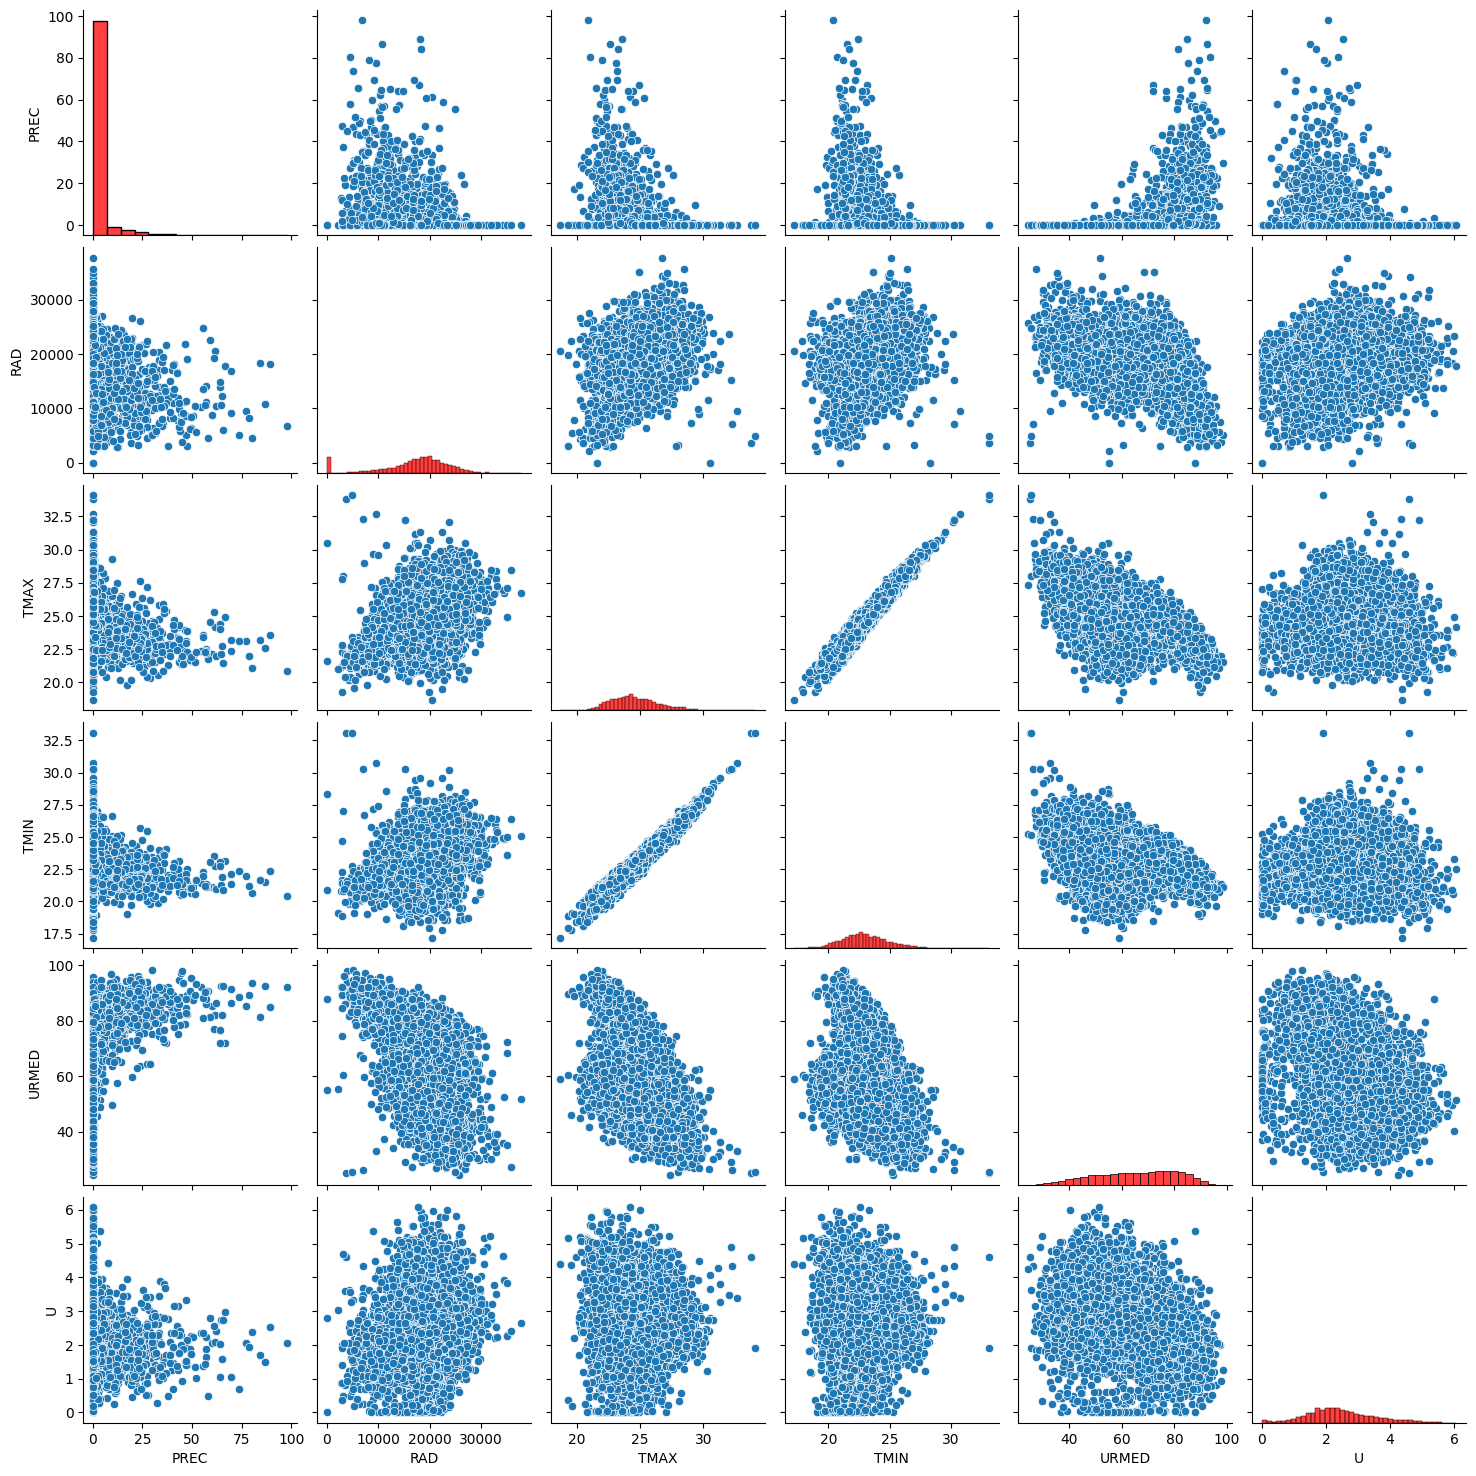

In [5]:
cols_to_plot = ['PREC', 'RAD', 'TMAX', 'TMIN', 'URMED', 'U']
sns.pairplot(df_lof[cols_to_plot], diag_kws={'color':'red'});

In [10]:
# Comparação entre IQR e LOF:

# Luíz Eduardo Magalhães - BA (A404)

def outliers_find(df_lof, x):
    q1  =  df_lof[x].quantile(.25)
    q3  =  df_lof[x].quantile(.75)
    iqr = q3-q1
    df_lof['IQR']  = np.where(df_lof[[x]] < (q1 - 1.5 * iqr), -1, np.where(df_lof[[x]] > (q3 + 1.5 * iqr), -1, 1))
    df_lof['LOF'] = LocalOutlierFactor(n_neighbors=20, novelty=True).fit(df_lof[[x]]).predict(df_lof[[x]])   
    return df_lof

outliers_find(df_lof,'PREC')

c:\Users\User\OneDrive\Documentos\GitHub\esalq_dados_clima\.venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


,Unnamed: 0,Data,PREC,RAD,TMAX,TMIN,URMED,U,IQR,LOF
0,0,2008-01-01,0.0,22780.17743,26.991667,25.333333,53.416667,2.337500,1,1
1,1,2008-01-02,0.0,25049.64575,26.112500,24.554167,64.437500,2.125000,1,1
2,2,2008-01-03,0.0,22079.97361,26.354167,24.966667,64.291667,2.220833,1,1
3,3,2008-01-04,0.0,37781.82600,26.737500,25.100000,51.645833,2.650000,1,1
4,4,2008-01-05,0.0,32782.26500,26.762500,24.675000,38.041667,2.550000,1,1
...,...,...,...,...,...,...,...,...,...,...
5474,5474,2022-12-27,0.2,18294.70772,24.562500,23.233333,79.550000,1.741667,-1,1
5475,5475,2022-12-28,0.0,24405.16000,25.095652,23.795652,74.194444,1.756522,1,1
5476,5476,2022-12-29,0.0,25117.38100,25.118182,23.636364,71.687500,1.500000,1,1
5477,5477,2022-12-30,0.0,22876.96630,25.656522,24.000000,74.976190,1.586957,1,1


In [11]:
df_lof['LOF'].value_counts() # Detectou somente 9 outliers com o LOF.

LOF
 1    5470
-1       9
Name: count, dtype: int64

In [12]:
df_lof['IQR'].value_counts() # Detectou somente 9 outliers com o LOF.

IQR
 1    4110
-1    1369
Name: count, dtype: int64

In [34]:
# Exemplo do LOF com um conjunto de dados sintético:

# Etapa 1: Criar conjunto ce dados com anomalias:
X, y = make_classification(n_samples=100000, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1, weights=[0.995, 0.005], class_sep=0.5, random_state=0)

# Converter os dados de array para dataframe:
df = pd.DataFrame({'feature1': X[:, 0], 'feature2': X[:, 1], 'target': y})

# Check the target distribution
df['target'].value_counts(normalize=True)

target
0   0.99
1   0.01
Name: proportion, dtype: float64

In [35]:
df

,feature1,feature2,target
0,1.24,0.58,0
1,-0.19,-0.02,0
2,-0.65,0.79,0
3,0.01,0.59,0
4,0.48,0.80,0
...,...,...,...
99995,-1.38,0.66,0
99996,-0.25,0.35,0
99997,-0.70,0.31,0
99998,-1.64,0.35,0


In [36]:
# Etapa 2: Divisão para teste e treinamento (o conjunto de treinamento precisa ter dado discrepante)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Número de registros no conjunto de dados de treinamento: ', X_train.shape[0])
print('Número de registros no conjunto de dados de teste: ', X_test.shape[0])

print(f"O conjunto de dados de treinamento tem {sorted(Counter(y_train).items())[0][1]} registros para a classe majoritária e {sorted(Counter(y_train).items())[1][1]} registros para a classe minoritária.")

Número de registros no conjunto de dados de treinamento:  80000
Número de registros no conjunto de dados de teste:  20000
O conjunto de dados de treinamento tem 79183 registros para a classe majoritária e 817 registros para a classe minoritária.


In [37]:
# Etapa 3: detecção de outlier com o LOF

lof_outlier = LocalOutlierFactor(n_neighbors=5, novelty=False)

# Predict novelties:
prediction_outlier = lof_outlier.fit_predict(X_test)

# Alterar os valores das anomalias para torná-los consistentes com os valores verdadeiros:
prediction_outlier = [1 if i==-1 else 0 for i in prediction_outlier]

# Verificar o desempenho do modelo:
print(classification_report(y_test, prediction_outlier))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19787
           1       0.06      0.03      0.04       213

    accuracy                           0.98     20000
   macro avg       0.53      0.51      0.52     20000
weighted avg       0.98      0.98      0.98     20000



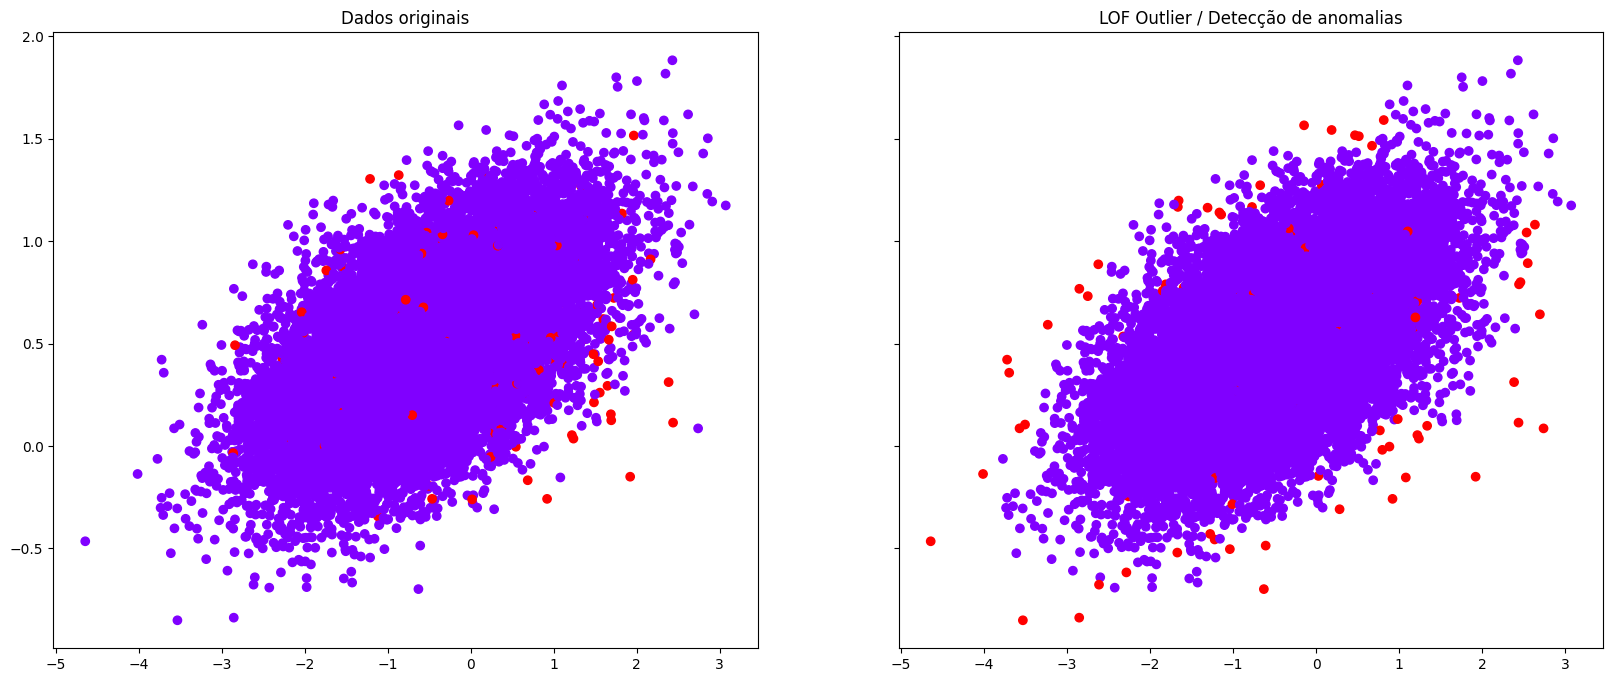

In [38]:
# Etapa 4: visualização

df_test = pd.DataFrame(X_test, columns=['feature1', 'feature2'])
df_test['y_test'] = y_test

df_test['prediction_outlier'] = prediction_outlier

fig, (ax0, ax1)=plt.subplots(1, 2, sharey=True, figsize=(20, 8))

# Ground truth
ax0.set_title('Dados originais')
ax0.scatter(df_test['feature1'], df_test['feature2'], c=df_test['y_test'], cmap='rainbow')

# Local Outlier Factor (LOF) Outlier / Detecção de anomalias
ax1.set_title('LOF Outlier / Detecção de anomalias')
ax1.scatter(df_test['feature1'], df_test['feature2'], c=df_test['prediction_outlier'], cmap='rainbow')

---
## Autoras:

* Profª. Drª. Patricia Angélica Alves Marques | **e-mail**: paamarques@usp.br 

* Doutoranda: Ângela Silviane Moura Cunha | **e-mail**: angelasilviane@usp.br